In [1]:
from pyspark.sql.functions import *

#import spark
from pyspark.sql import SparkSession
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ass2 BNPL group 28")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/09/14 11:54:52 WARN Utils: Your hostname, Rudyletsgo resolves to a loopback address: 127.0.1.1; using 172.25.148.241 instead (on interface eth0)
22/09/14 11:54:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/09/14 11:54:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
## read main and external dataset
curated_csv = spark.read.options(header = True).csv('../data/curated/clean-data.csv')
postcode_SA2 = spark.read.options(header = True).csv('../data/tables/postcode_SA2.csv')
population = spark.read.options(header = True).csv('../data/tables/2021Census_G01_AUST_SA2.csv')
income = spark.read.options(header = True).csv('../data/tables/2021Census_G02_AUST_SA2.csv')

In [3]:
curated_csv.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- dollar_value: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- field: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: string (nullable = true)



In [4]:
postcode_SA2.printSchema()

root
 |-- POA_CODE_2021: string (nullable = true)
 |-- SA2_CODE_2021: string (nullable = true)
 |-- SA2_NAME_2021: string (nullable = true)



In [5]:
postcode_SA2.count()

11858

In [6]:
population.printSchema()

root
 |-- SA2_CODE_2021: string (nullable = true)
 |-- Tot_P_M: string (nullable = true)
 |-- Tot_P_F: string (nullable = true)
 |-- Tot_P_P: string (nullable = true)
 |-- Age_0_4_yr_M: string (nullable = true)
 |-- Age_0_4_yr_F: string (nullable = true)
 |-- Age_0_4_yr_P: string (nullable = true)
 |-- Age_5_14_yr_M: string (nullable = true)
 |-- Age_5_14_yr_F: string (nullable = true)
 |-- Age_5_14_yr_P: string (nullable = true)
 |-- Age_15_19_yr_M: string (nullable = true)
 |-- Age_15_19_yr_F: string (nullable = true)
 |-- Age_15_19_yr_P: string (nullable = true)
 |-- Age_20_24_yr_M: string (nullable = true)
 |-- Age_20_24_yr_F: string (nullable = true)
 |-- Age_20_24_yr_P: string (nullable = true)
 |-- Age_25_34_yr_M: string (nullable = true)
 |-- Age_25_34_yr_F: string (nullable = true)
 |-- Age_25_34_yr_P: string (nullable = true)
 |-- Age_35_44_yr_M: string (nullable = true)
 |-- Age_35_44_yr_F: string (nullable = true)
 |-- Age_35_44_yr_P: string (nullable = true)
 |-- Age_45_54

In [7]:
income.printSchema()

root
 |-- SA2_CODE_2021: string (nullable = true)
 |-- Median_age_persons: string (nullable = true)
 |-- Median_mortgage_repay_monthly: string (nullable = true)
 |-- Median_tot_prsnl_inc_weekly: string (nullable = true)
 |-- Median_rent_weekly: string (nullable = true)
 |-- Median_tot_fam_inc_weekly: string (nullable = true)
 |-- Average_num_psns_per_bedroom: string (nullable = true)
 |-- Median_tot_hhd_inc_weekly: string (nullable = true)
 |-- Average_household_size: string (nullable = true)



In [8]:
## Drop unhelpful columns in both external dataset
population = population.select(col('SA2_CODE_2021'), col('Tot_P_P'))
income = income.select(col('SA2_CODE_2021'), col('Median_tot_prsnl_inc_weekly'))

## change data type
population = population.withColumn("Tot_P_P",population.Tot_P_P.cast('int'))
income = income.withColumn('Median_tot_prsnl_inc_weekly', income.Median_tot_prsnl_inc_weekly.cast('float'))

In [9]:
## merge SA2 population (sum of different sa2 areas) with postcode
pos_population = postcode_SA2.join(population, postcode_SA2.SA2_CODE_2021 == population.SA2_CODE_2021, "inner").drop(population.SA2_CODE_2021)
pos_population = pos_population.groupBy('POA_CODE_2021').sum('Tot_P_P')
pos_population = pos_population.withColumnRenamed('sum(Tot_P_P)', 'total_population')

pos_population.show(3)

+-------------+----------------+
|POA_CODE_2021|total_population|
+-------------+----------------+
|         2136|           67075|
|         4821|          212922|
|         2088|           28328|
+-------------+----------------+
only showing top 3 rows



In [10]:
## merge SA2 income (average personal income in different sa2 areas) with postcode
pos_income= postcode_SA2.join(income, postcode_SA2.SA2_CODE_2021 == income.SA2_CODE_2021, "inner").drop(income.SA2_CODE_2021)
pos_income = pos_income.groupBy('POA_CODE_2021').avg('Median_tot_prsnl_inc_weekly')
pos_income = pos_income.withColumn("avg_personal_income_weekly", round(pos_income["avg(Median_tot_prsnl_inc_weekly)"], 1))
pos_income = pos_income.drop('avg(Median_tot_prsnl_inc_weekly)')

pos_income.show(3)

+-------------+--------------------------+
|POA_CODE_2021|avg_personal_income_weekly|
+-------------+--------------------------+
|         2136|                     813.0|
|         4821|                     833.2|
|         2088|                    1487.0|
+-------------+--------------------------+
only showing top 3 rows



In [11]:
## join both income and population with postcode
pos_info = pos_population.join(pos_income, pos_population.POA_CODE_2021 == pos_income.POA_CODE_2021, 'inner').drop(pos_income.POA_CODE_2021)

pos_info = pos_info.select('POA_CODE_2021', 'total_population', 'avg_personal_income_weekly')

pos_info.show(3)

+-------------+----------------+--------------------------+
|POA_CODE_2021|total_population|avg_personal_income_weekly|
+-------------+----------------+--------------------------+
|         2069|          102475|                    1149.7|
|         2088|           28328|                    1487.0|
|         2136|           67075|                     813.0|
+-------------+----------------+--------------------------+
only showing top 3 rows



In [12]:
## join pos_info with original dataset
curated_csv_new = curated_csv.join(pos_info, curated_csv.postcode == pos_info.POA_CODE_2021, "inner").drop(pos_info.POA_CODE_2021)



In [13]:
print('Number of transaction before join with pos_info:', str(curated_csv.count()))
print('Number of transaction after join with pos_info:', str(curated_csv_new.count()))


Number of transaction before join with pos_info: 11873781


Number of transaction after join with pos_info: 9930293


In [14]:
curated_csv_sample = curated_csv.sample(0.1).select('dollar_value')
curated_csv_new_sample = curated_csv_new.sample(0.1).select('dollar_value')

In [15]:
curated_csv_new_sample = curated_csv_new_sample.toPandas()
curated_csv_sample = curated_csv_sample.toPandas()

In [17]:
curated_csv_new_sample['dollar_value']=curated_csv_new_sample['dollar_value'].astype(float)
curated_csv_sample['dollar_value']=curated_csv_sample['dollar_value'].astype(float)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

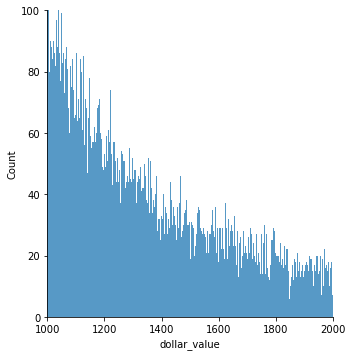

In [32]:
sns.displot(curated_csv_sample, x='dollar_value')
plt.xlim(1000, 2000)
plt.ylim(0,100)
plt.show()

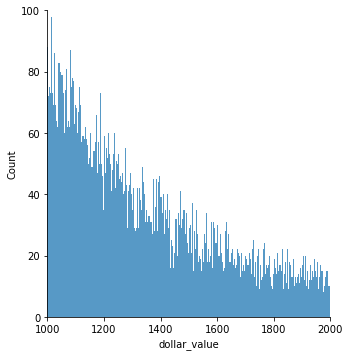

In [33]:
sns.displot(curated_csv_new_sample, x='dollar_value')
plt.xlim(1000, 2000)
plt.ylim(0,100)
plt.show()

In [36]:
bar_old = curated_csv.sample(0.1).groupby('revenue_level').count()
bar_new = curated_csv_new.sample(0.1).groupby('revenue_level').count()

In [39]:
bar_old.withColumn("type", lit(0))


revenue_level,count,type
e,10393,0
d,11737,0
c,290290,0
b,341650,0
a,533300,0


In [40]:
bar_new.withColumn("type", lit(1))

revenue_level,count,type
e,8832,1
d,9919,1
c,242438,1
b,286760,1
a,446332,1


In [50]:
bar_new = bar_new.toPandas()
bar_old = bar_old.toPandas()

<AxesSubplot:xlabel='revenue level'>

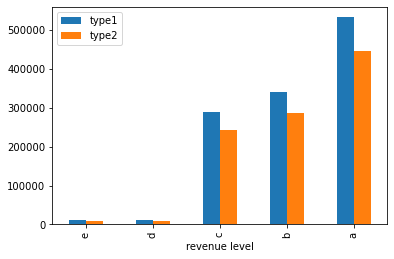

22/09/14 13:48:10 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 3203904 ms exceeds timeout 120000 ms
22/09/14 13:48:10 WARN SparkContext: Killing executors is not supported by current scheduler.


In [51]:
import pandas as pd
df = pd.DataFrame({
    'revenue level': bar_new['revenue_level'],
    'type1': bar_old['count'],
    'type2': bar_new['count']
})
  
# plotting graph
df.plot(x="revenue level", y=["type1", "type2"], kind="bar")

In [43]:
combine = bar_old.union(bar_new)
combine = combine.toPandas()

In [48]:
combine.plot(x="revenue_level", y="type", kind="bar")

KeyError: 'type'